In [1]:
%load_ext autoreload
%autoreload 2

# add the parent directory in the path to import the packages
import sys
sys.path.append('../')

import plotly.express as px
from WaterClassification.core import *
from WaterClassification.Radiometry import RadiometryDB, Radiometry
from WaterClassification.Fitting import *
from pathlib import Path
from functools import partial


# Baseline

This notebook has the objective to establish a baseline to compare further inversion algorithms. <br>
The basic assumptions are:
* Two models will be created. One using high and low SPM separation, and another one adjusting one model for each Area (Basin)
* In the high/low model the SPM concentration will define which formula to use. As the SPM is not known beforehand, another wavelenght (from the satellite possibilities) will be used as a proxy.
* In the Area model, a formula will be calculated for each different Area/Basin
* The bands to be searched will be those from <b>SENTINEL 3</b>
* We will try to fit original and normalized Bands

## Load the database
First we will load the database and clean unwanted Flags

In [2]:
db = RadiometryDB(r'D:\OneDrive - Agência Nacional de Águas\Data\GET-RadiometryDB')
# db.update_metadata(attrs=RadiometryDB.default_attrs)
# db.create_summary_radiometries()

db.load_radiometries(r_types=['Rrs', 'Rrs_OSOAA'], 
                     norm=True,                                                      # create the normalized bands and also the area
                     funcs=partial(calc_area, col_name='flatness', norm_band='700'),  # create the flatness band
                     qry="SPM > 0 and Status != 'Deleted' and Status != 'Suspicious'"                            # clear deleted and no data
                    )

Radiometries ['Rrs', 'Rrs_OSOAA'] loaded in dictionary .rdmtries


In [3]:
rrs = db.rdmtries['Rrs']
rrs = rrs[(rrs['SPM']>0) & (rrs['Status'] != 'Deleted')]
rrs.head()

Area_2 Station_2    Measurement         Start_Date_2  SPM_2 Status_2  \
Id                                                                             
0   Descoberto   Ponto_1  20160318-1139  2016-03-18 11:39:00    7.0       Ok   
1   Descoberto   Ponto_2  20160318-1214  2016-03-18 12:14:00    8.4       Ok   
2   Descoberto   Ponto_3  20160318-1228  2016-03-18 12:28:00    5.8       Ok   
3   Descoberto   Ponto_4  20160318-1325  2016-03-18 13:25:00    6.2       Ok   
4   Descoberto   Ponto_5  20160318-1347  2016-03-18 13:47:00    8.4       Ok   

         Description_2  319       320       321  ...      n943      n944  \
Id                                               ...                       
0   GIANCARLO_ CAMP1_1  NaN  0.003272  0.003054  ...  0.000138  0.000127   
1   GIANCARLO_ CAMP1_2  NaN  0.002663  0.002460  ...  0.000193  0.000212   
2   GIANCARLO_ CAMP1_3  NaN  0.003356  0.003116  ...  0.000143  0.000146   
3   GIANCARLO_ CAMP1_4  NaN  0.003155  0.002964  ...  0.000190  0.000192   
4   GIANCARLO_ CAMP1_5  NaN  0.001636  0.001477  ...  0.000184  0.000185   

        n945      n946      n947      n948      n949      n950  n951  flatness  
Id                                                                              
0   0.000149  0.000184  0.000180  0.000186  0.000191  0.000213   NaN -1.480905  
1   0.000206  0.000210  0.000192  0.000204  0.000186  0.000189   NaN -1.484569  
2   0.000142  0.000146  0.000158  0.000165  0.000162  0.000154   NaN -1.755808  
3   0.000192  0.000200  0.000200  0.000206  0.000201  0.000198   NaN -1.554886  
4   0.000192  0.000192  0.000182  0.000179  0.000190  0.000186   NaN -3.310058  

[5 rows x 1289 columns]

In [4]:
# deleting outliers
rrs.drop(index=[410, 418, 390, 520, 409, 658], inplace=True, errors='ignore')
len(rrs)

869

## Preparing Bands and Columns

In [5]:
bands = s3bands + s3bands_norm + ['b865/b665']

# One Model for Each Area/Basin

In [61]:
gfit = GroupFit(rrs, bands, BaseFit.available_funcs, 'Area', metric=BaseFit.rmsle, thresh=10, n_cpus=6, optimize_metric=True)

In [62]:
gfit.summary()

func       band     R^2         MSE      RMSE  \
Indaia                   Power        865  0.9350    476.1592   21.8211   
Madeira            Exponential  b865/b665  0.7652  22835.6150  151.1146   
Paranapanema             Power        779  0.7752     31.4354    5.6067   
Paranoa                  Power        754  0.7939      5.4258    2.3293   
Paraopeba          Exponential        865  0.4659    298.6969   17.2829   
Purus                    Power        709  0.8452   1631.8867   40.3966   
Sao_Francisco           Linear  b865/b665  0.9795     69.5044    8.3369   
Solimoes_Amazonas        Power  b865/b665  0.7404   1205.8816   34.7258   
Maroni             Exponential        709  0.9025      3.8929    1.9730   
Saut_Hermina       Exponential        709  0.8600     14.9003    3.8601   
Bagre                    Power  b865/b665  0.9616   1694.0368   41.1587   
Negro                    Power        681  0.6213      9.0830    3.0138   
Ucayali                  Power  b865/b665  0.8553  20737.8240  144.0063   
Mekong                   Power        865  0.7730   2755.0213   52.4883   
Solimoes_Varzea          Power        754  0.5935    127.9114   11.3098   
overall                    NaN        NaN  0.9162   6461.7814   80.3852   

                    RMSLE           SSE  \
Indaia             0.1968  6.190070e+03   
Madeira            0.2841  4.019068e+06   
Paranapanema       0.5280  1.288853e+03   
Paranoa            0.3983  5.208757e+02   
Paraopeba          0.3198  4.181757e+03   
Purus              0.3306  5.548415e+04   
Sao_Francisco      0.0994  1.529097e+03   
Solimoes_Amazonas  0.3207  1.169705e+05   
Maroni             0.0621  1.128938e+02   
Saut_Hermina       0.1069  4.321080e+02   
Bagre              0.1989  3.557477e+04   
Negro              0.6159  1.380614e+03   
Ucayali            0.2090  1.140580e+06   
Mekong             0.2838  3.857030e+04   
Solimoes_Varzea    0.3797  6.011835e+03   
overall            0.3872  5.427896e+06   

                                                              params  qty  
Indaia             [15370.531744298973, 1.1687134387287905, -0.43...   13  
Madeira                    [148.07290970415295, -191.31149445732734]  176  
Paranapanema       [43286.02656417752, 1.5667246296444655, 1.5386...   41  
Paranoa            [775.0572366511518, 0.776128546921206, -0.1142...   96  
Paraopeba                    [1573.511480273255, -1566.106683910276]   14  
Purus              [14358.414477406812, 1.6998876330864578, 4.278...   34  
Sao_Francisco                [599.4127475393587, -49.64296812919049]   22  
Solimoes_Amazonas  [1406.077373870462, 2.3283172786091195, 15.251...   97  
Maroni                       [603.7741445991758, -602.7195979091155]   29  
Saut_Hermina                 [581.5704636851825, -581.0094765876715]   29  
Bagre              [768.2014284958069, 1.7820527373676094, -6.520...   21  
Negro              [4983.737925737672, 1.4297876658272681, 1.2268...  152  
Ucayali            [1697.0548377722384, 3.590769335247677, 215.32...   55  
Mekong             [5420.92681837071, 0.8373383667881285, -6.6732...   14  
Solimoes_Varzea    [379.1385136736076, 0.5426162938817204, -5.257...   47  
overall                                                         None  840

<b>OBS:</b> The problem with this approach is that many basins that had less than 10 points were discarded

In [69]:
count_by_area = rrs.groupby(by='Area')['Measurement'].count()
count_by_area[count_by_area<10]

Area
Descoberto    6
Ica           3
Japura        3
Javari        2
Jurua         2
Jutai         1
Lago_Tefe     2
Maranon       2
Napo          2
Oiapoque      4
Tapajos       2
Name: Measurement, dtype: int64

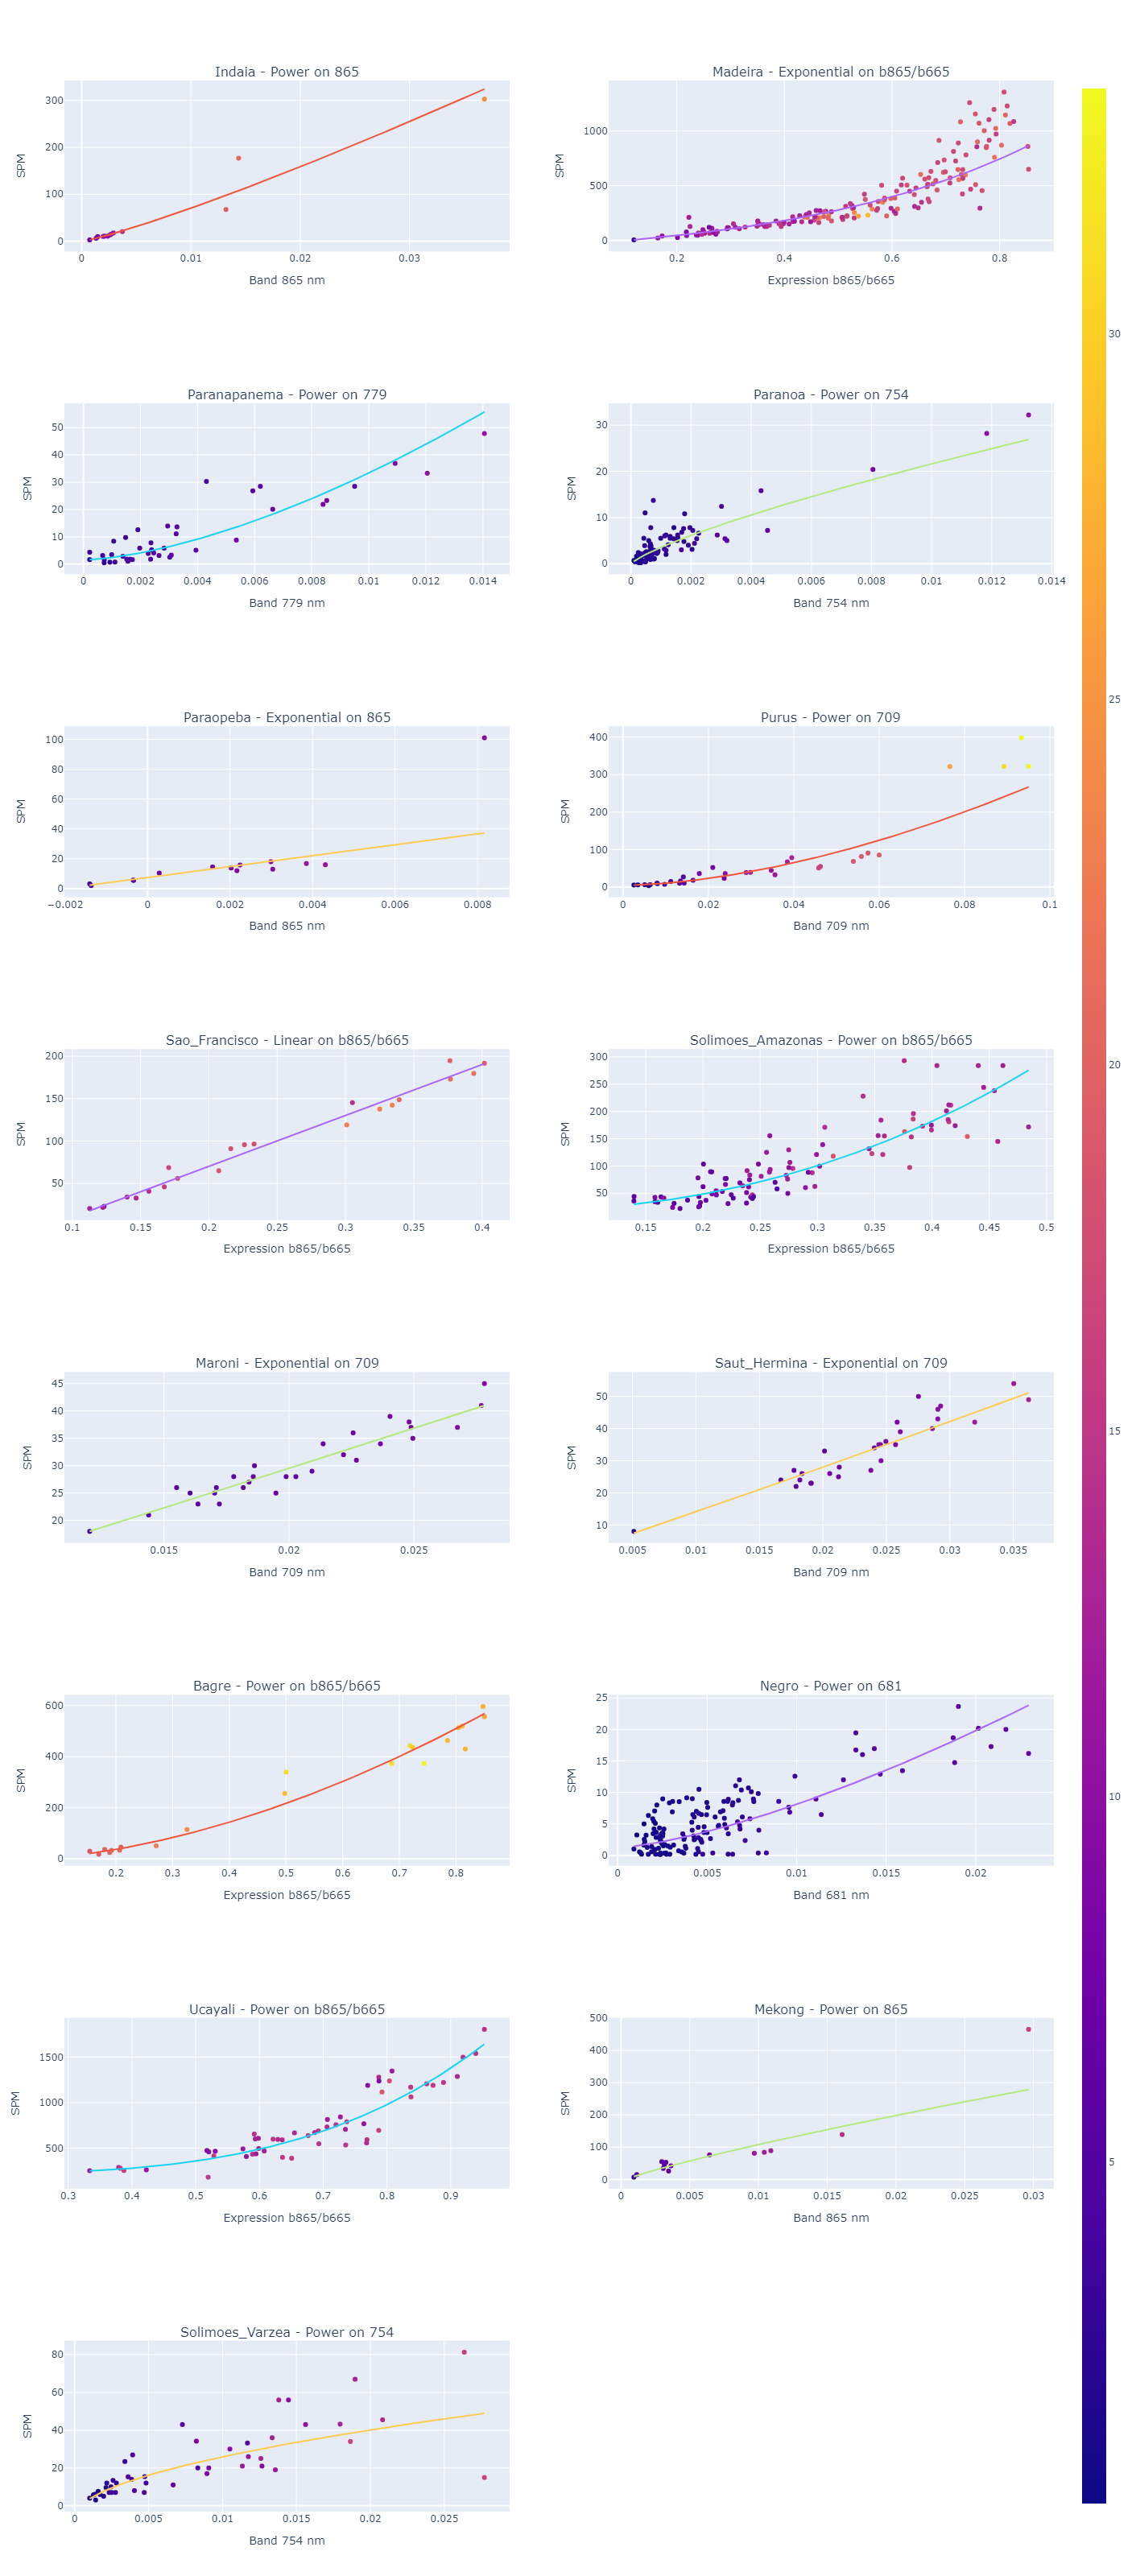

In [75]:
gfit.plot_groups(cols=2, base_height=400, color='area', hover_data='Station')

# One model for High and Low concentration

## Fitting to Low vs High SPM concentrations 
We know "<i>a priori</i>" that the reflectance curve changes it's shape according to the concentration, so it is not feasible to use just one function for all the SPM range (0 to 1200mg/l), for example. Here is a brief test cutting the dataset into low and high concentrations and testing the overall fitting.

In [70]:
low = rrs[rrs['SPM'] < 80]
high = rrs[rrs['SPM'] >= 80]

In [93]:
mfit_high = MultiFit(high, bands, BaseFit.available_funcs, expr_y='SPM', metric=BaseFit.rmsle, n_cpus=6, optimize_metric=True)

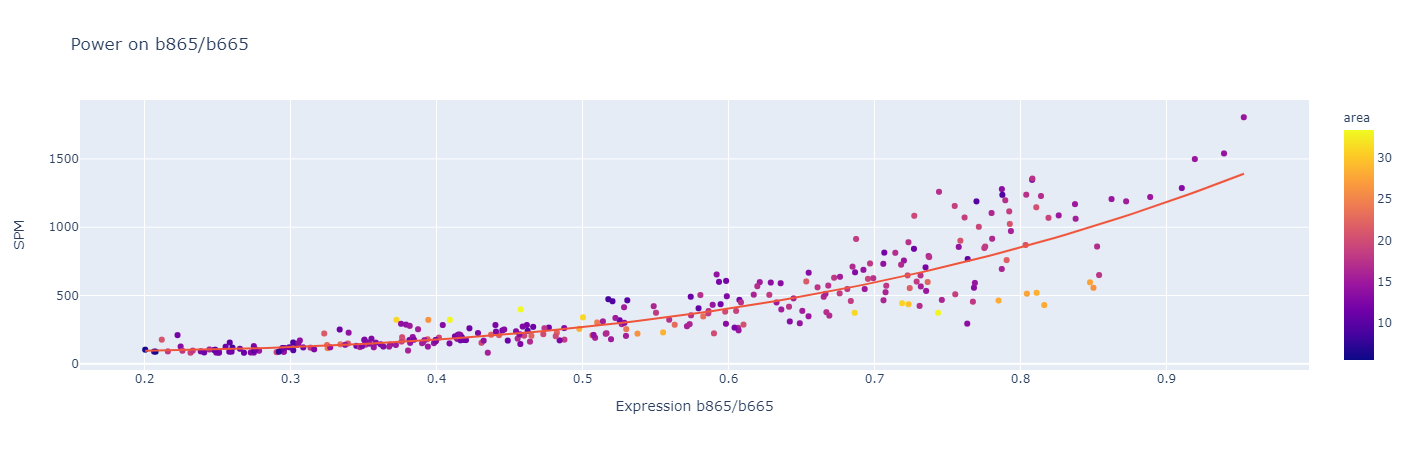

In [94]:
mfit_high.plot_best_fit(color='area', update_layout=dict(showlegend=False)) 

In [95]:
mfit_high.summary()

func       band     R^2      MSE     RMSE  \
Power on b865/b665              Power  b865/b665  0.8094  21309.8  145.979   
Exponential on b865/b665  Exponential  b865/b665  0.7575    27113   164.66   
Linear on b865/b665            Linear  b865/b665  0.5949  45289.4  212.813   
Exponential on 920        Exponential        920   0.378  69544.9  263.714   
Linear on 920                  Linear        920  0.3784  69498.6  263.626   

                           RMSLE          SSE  \
Power on b865/b665        0.2788  6.62734e+06   
Exponential on b865/b665  0.2973  8.43214e+06   
Linear on b865/b665       0.3682   1.4085e+07   
Exponential on 920        0.4952  2.16285e+07   
Linear on 920             0.4957  2.16141e+07   

                                                                     params  \
Power on b865/b665        [1514.201427476508, 3.041498366099086, 83.7149...   
Exponential on b865/b665          [144.17956331705068, -161.59291319124566]   
Linear on b865/b665                [928.4992255039381, -138.70469859001406]   
Exponential on 920                    [9961.9593817181, -9962.727726404213]   
Linear on 920                       [23556.15579510456, -3.126806538235106]   

                          qty  
Power on b865/b665        311  
Exponential on b865/b665  311  
Linear on b865/b665       311  
Exponential on 920        311  
Linear on 920             311

In [96]:
mfit_low = MultiFit(low, bands, BaseFit.available_funcs, expr_y='SPM', metric=BaseFit.rmsle, n_cpus=6, optimize_metric=True)

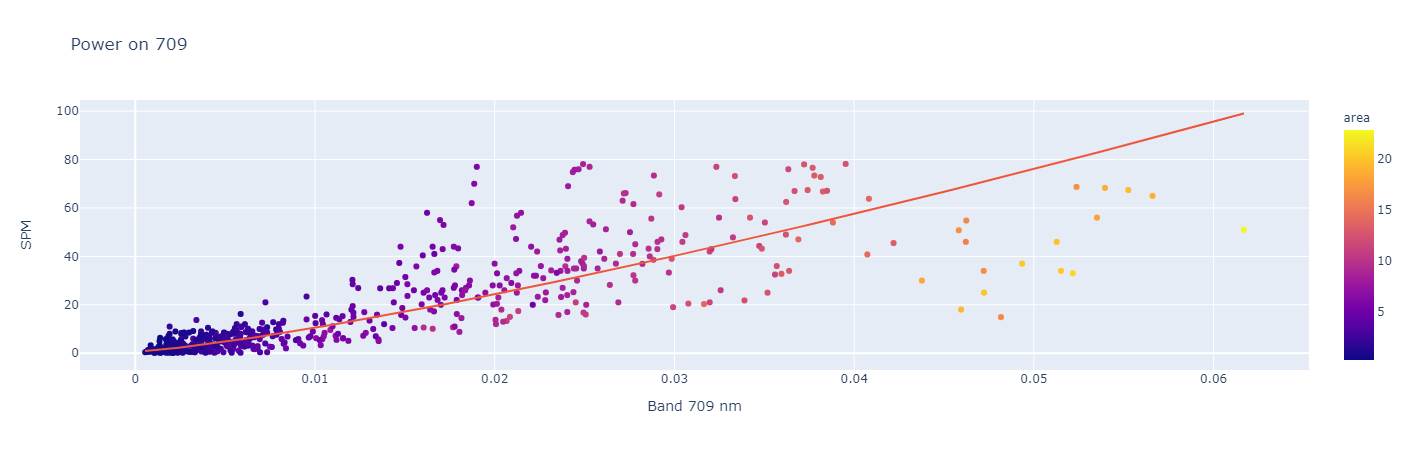

In [97]:
mfit_low.plot_best_fit(color='area', update_layout=dict(showlegend=False))

In [98]:
mfit_low.summary()

func band     R^2      MSE     RMSE   RMSLE  \
Power on 709              Power  709  0.6243  150.827  12.2812  0.5327   
Exponential on 709  Exponential  709  0.6487  141.036  11.8759  0.5431   
Nechad on 709            Nechad  709  0.6564  137.966  11.7459  0.5432   
Linear on 709            Linear  709  0.6496   140.69  11.8613  0.5444   
Power on 681              Power  681  0.5985  161.214   12.697  0.5792   

                        SSE  \
Power on 709        84161.6   
Exponential on 709  78698.4   
Nechad on 709       76985.2   
Linear on 709       78504.8   
Power on 681        89957.7   

                                                               params  qty  
Power on 709        [3332.0131449151386, 1.2644561616013572, 0.653...  558  
Exponential on 709           [503.0554878434543, -503.39064498639476]  558  
Nechad on 709       [377.7394850826676, 1.6115789817139063, -0.381...  558  
Linear on 709                [1186.755046475181, -0.3819344077306252]  558  
Power on 681        [2634.5202737770596, 1.267960305700246, 0.6555...  558

In [101]:
BaseFit.test_combined_fit([mfit_high.best_fit, mfit_low.best_fit])

{R^2: 0.8971, MSE: 7723.244, RMSE: 87.882, RMSLE: 0.4583, SSE: 6711499.0442}

## Defining the PROXY band
The problem with the aforementioned result is that we don't know beforehand the SPM value to "choose" the correct model to use. Instead, we should define a cutoff band/value for this. Considering we are using S3 satellite, we shall test it's bands for a good combination.

### Warning: This step takes a long time to execute

In [ ]:
proxy_bands = ['510', '560', '620', '665', '709', '865', '885', 'area']
str(proxy_bands)

In [ ]:
def test_cutoff_value(df, cutoff_band, fit_bands, fit_funcs, n_tests=5):
    # tests the cutoff value for a dataset and a given band. 
    # The values to be tested will be retrieved from the percentiles of the bands series. 
    # n_tests is the number of percentiles used for testing
    # if n_tests = 1, just the middle point (0.5) will be tested
    # The results will be a list with the test results
    
    # listify the fit bands and funcs
    fit_bands, fit_funcs = listify(fit_bands, fit_funcs)
    
    # as the "cutoff_band" may be an expression, we will parse it beforehand
    parsed_band = DfFit.parse_expr_df(df, cutoff_band)
    
    # get the percentiles to be tested and corresponding values
    percentiles = np.linspace(0, 1, n_tests + 2)[1: -1]
    testing_values = [parsed_band.quantile(q) for q in percentiles]
    
    print(f'Testing band {cutoff_band}:')
    
    results = {}
    for cutoff, quantile in zip(testing_values, percentiles):
        print(f'calculating error for Quantile:{round(quantile, 3)} CutoffValue: {cutoff:0.3f}')
        
        high = df[parsed_band > cutoff]
        low = df[parsed_band <= cutoff]      
        
        # do the normal fitting for the two datasets
        mfit_high = MultiFit(high, fit_bands, fit_funcs, expr_y='SPM', metric='rmsle', criteria='min')
        mfit_low = MultiFit(low, fit_bands, fit_funcs, expr_y='SPM', metric='rmsle', criteria='min')
        
        result = Fit.test_combined_fit([mfit_high.get_best_fit_obj(), mfit_low.get_best_fit_obj()])
        results[quantile] = result
    return results

def save_cutoff_result(band, result_dict, base_path='./'):
    # create a dataframe with the results (quantiles and metrics)
    df = pd.DataFrame(result_dict)
    
    # create a multi_index to add the band
    df.index = pd.MultiIndex.from_product([[band], df.index], names=['band', 'metric'])

    # save to a pickle file, into the specified folder
    fname = Path(base_path)/f'Cutoff_Band_{band}.pickle'
    df.to_pickle(fname)

In [ ]:
# Loop through the possible bands to serve as proxy
# bands = bands + ['flatness']

for band in proxy_bands:
    cutoff_result = test_cutoff_value(rrs, band, bands, Fit.available_funcs, n_tests=20)
    save_cutoff_result(band, cutoff_result, base_path='./cutoff_results')
    

In [ ]:
df = None
for band in proxy_bands:
    band_result = pd.read_pickle(f'./cutoff_results/Cutoff_Band_{band}.pickle')
    
    df = band_result if df is None else pd.concat([df, band_result])
df

In [ ]:
df.index = df.index.swaplevel()

In [ ]:
px.line(df.loc['rmsle'].loc[proxy_bands].T)

In [6]:
band = '709'
quantile = 0.428

rrs.loc[(rrs[band]<=rrs[band].quantile(quantile)), 'Group'] = 'low'
rrs.loc[(rrs[band]>rrs[band].quantile(quantile)), 'Group'] = 'high'

In [7]:
gfit = GroupFit(rrs, bands, BaseFit.available_funcs, 'Group', metric=BaseFit.rmsle, thresh=10, n_cpus=6, optimize_metric=True)

In [8]:
gfit.summary()

func  band     R^2         MSE      RMSE   RMSLE  \
low      Exponential   709  0.4517     55.8002    7.4700  0.5817   
high           Power  n865  0.8153  18787.0413  137.0658  0.3840   
overall          NaN   NaN  0.8565  10768.6044  103.7719  0.4787   

                  SSE                                             params  qty  
low      2.075768e+04           [433.42088464138726, -433.4260179005288]  372  
high     9.337160e+06  [1561253831235.0117, 3.408033960270617, 18.681...  497  
overall  9.357917e+06                                               None  869

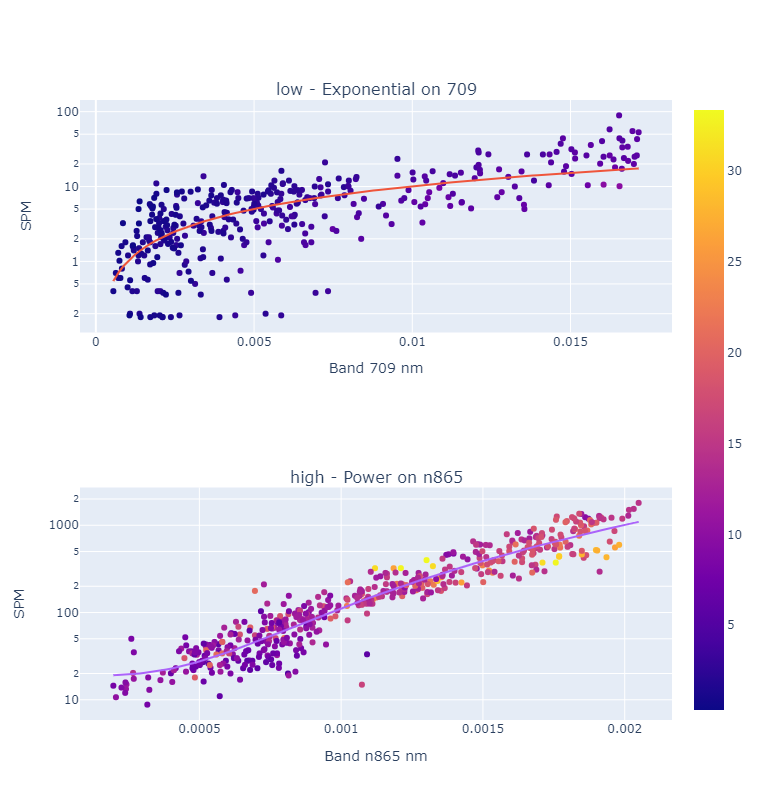

In [9]:
gfit.plot_groups(cols=1, base_height=400, color='area', log_y=True)

We can note that the low model has a problem in the interface between low and high, with 709 higher than 0.015. If we take some samples we can see that there are two different classes with 709 higher than 0.015 (graph bellow). So the proxy should check for two parameters: 709 reflectance and also ratio. 

In [10]:
# plot_ids(rrs, [745, 14, 671], bands=all_wls, )

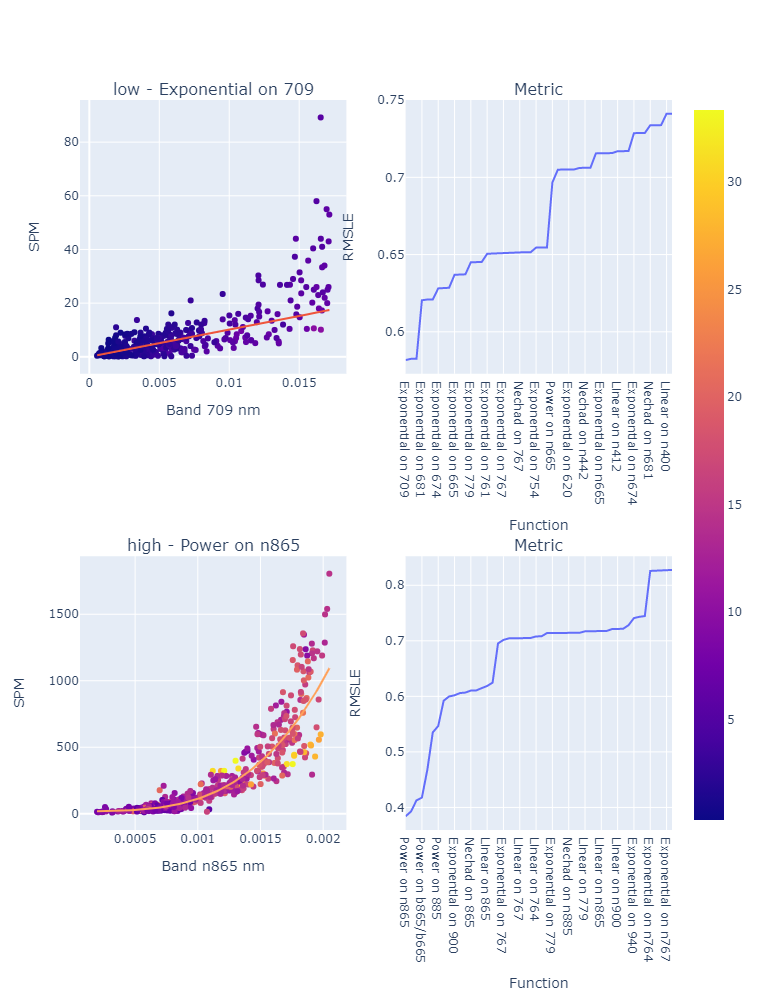

In [11]:
gfit.plot_groups_summary(color='area')